### **Distributed Profiling with JAX HPC Profiler**

This notebook demonstrates how to use the `jax_hpc_profiler` package for distributed profiling in a multi-device setup. By utilizing environment variables to configure JAX for multi-device execution, we can simulate distributed environments and gather performance data for analysis. The notebook walks through setting up profiling for large-scale computations, capturing performance metrics, and generating visualizations for scalability analysis.

In [1]:
import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=32"
import jax
import jax.numpy as jnp
from jax_hpc_profiler import Timer

In this section, a JAX function mma is defined to perform matrix multiplication and addition, optimized using the JIT compiler.

In [2]:
# Define JAX functions
@jax.jit
def mma(m, n, k):
    return jnp.dot(m, n) + k

### **Distributed Profiling with Multiple Devices**

This section demonstrates profiling on multiple devices (using 4, 8, 16, and 32 devices) in a distributed JAX setup, where matrices are sharded across the devices for parallel computation. The performance is then measured and reported for different matrix sizes.

In [3]:
from jax import lax
from jax.sharding import NamedSharding, PartitionSpec as P

for n_devices in [4, 8, 16, 32]:
    devices = jax.devices()[:n_devices]
    timer = Timer(devices=devices)
    mesh = jax.make_mesh((len(devices),), ("x",), devices=devices)
    sharding = NamedSharding(mesh, P("x"))

    for size in [128, 256, 512, 1024]:
        # JAX Matrices
        m_jax = jnp.ones((size, size))
        n_jax = jnp.ones((size, size))
        k_jax = jnp.ones((size, size))

        # JAX Sharded Matrices
        m_jax = lax.with_sharding_constraint(m_jax, sharding)
        n_jax = lax.with_sharding_constraint(n_jax, sharding)
        k_jax = lax.with_sharding_constraint(k_jax, sharding)

        timer.chrono_jit(mma, m_jax, n_jax, k_jax)
        for _ in range(10):
            timer.chrono_fun(mma, m_jax, n_jax, k_jax)

        kwargs = {
            "function": "mma",
            "precision": "float32",
            "x": size,
            "y": size,
            "px": n_devices,
            "py": 1,
        }
        extra_info = {"done": "yes"}
        timer.report("JAX_MULTI.csv", **kwargs, extra_info=extra_info)

### **Visualizing Weak and Strong Scaling Performance**

This section generates visualizations for both **weak scaling** and **strong scaling** based on the distributed profiling results stored in `JAX_MULTI.csv`. 

- **Weak Scaling**: Measures performance when the problem size increases in proportion to the number of devices, helping assess how well the system scales.
- **Strong Scaling**: Measures how performance changes as the number of devices increases, with a fixed problem size.

These plots help evaluate the efficiency and scalability of the distributed system.

requested GPUS: None available GPUS: {np.int64(8), np.int64(16), np.int64(32), np.int64(4)}
requested data sizes: None available data sizes: {np.int64(128), np.int64(256), np.int64(512), np.int64(1024)}


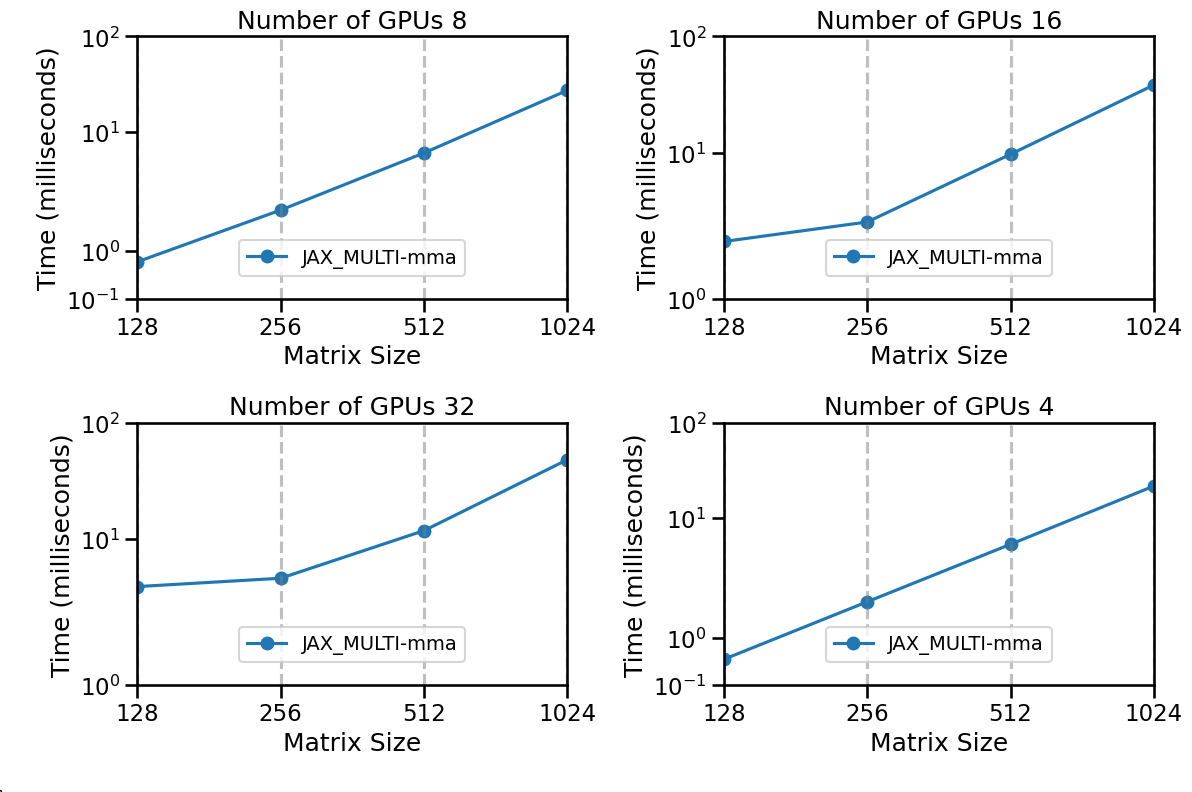

requested GPUS: None available GPUS: {np.int64(8), np.int64(16), np.int64(32), np.int64(4)}
requested data sizes: None available data sizes: {np.int64(128), np.int64(256), np.int64(512), np.int64(1024)}


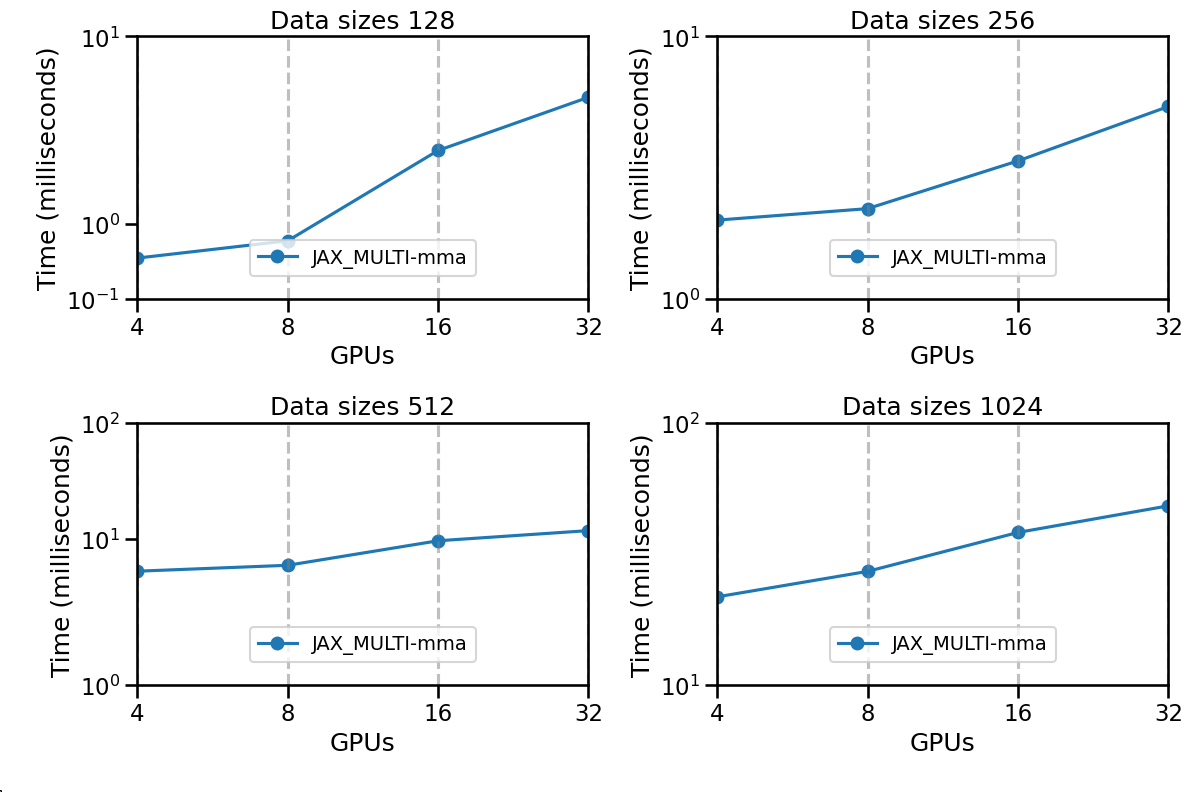

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from jax_hpc_profiler.plotting import plot_weak_scaling, plot_strong_scaling

plt.rcParams.update({"font.size": 15})

sns.set_context("talk")

csv_file = ["JAX_MULTI.csv"]

plot_weak_scaling(
    csv_files=csv_file,
    figure_size=(12, 8),
    label_text="%m%-%f%",
    xlabel="Matrix Size",
)

plot_strong_scaling(
    csv_files=csv_file,
    figure_size=(12, 8),
    label_text="%m%-%f%",
    xlabel="GPUs",
)